# DSCI 100 GROUP 15 Report

### Hyunseok Jung, Jordan Sanders, Ivie Huang, Eden Vasica

## Introduction

The government of Canada provides historical data on weather and climate. Its' hourly weather data report consists of various climate observations such as temperature, humidity, and wind speed, as well as a column classifying the weather type (e.g. "Mostly Cloudy"). We are excited to test our ability to build a classification model for weather types based on climate observations from this dataset. To make our project more enjoyable and personal, we decided to work with historical weather and climate data provided by the 'Vancouver Intl A' weather station, which is not far from UBC. This facility, located in the Vancouver International Airport, is one of the most significant weather stations in Vancouver that collects measurements for weather forecasts and climate studies hourly. Unlike hourly data reports, daily and monthly data reports do not include a weather column making it impossible to build a classification model.

Considering seasonal climate differences and fluctuations, we decided to focus on weather reports from June, to reduce the number of external factors affecting the observations. As we will be handling an hourly data report, we have sufficient observations to build a classification model. In addition, to minimize the influence of global warming on temperature for our classification model, we will use recent data to train our model: June 2020 and June 2021. For the testing set, we will be using reports from June 2022, which will allow us to use the most recent weather data available to check the accuracy of our classification model.

## Methods & Results

(describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.)

In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(themis)

ERROR: Error in library(themis): there is no package called ‘themis’


In [11]:
options(repr.matrix.max.rows = 9)
set.seed(2022) #we need this to make our code reproducible, since sample is a random function

weather_data <- read_csv("https://raw.githubusercontent.com/hyunseokjg/DSCI100-Group15-Project/main/data/testing_set.csv")
weather_data

#Let's remove the very rare weather classes for simplicity and so we do not overreppresent them when we balance our data

filtered_weather_data <- weather_data %>%
    filter(Weather != "Heavy Rain", 
           Weather != "Moderate Rain",
           Weather != "Clear",
           Weather != "Moderate Rain,Fog") %>%
    mutate(Weather = as_factor(Weather)) %>%
    sample_n(500)
filtered_weather_data

#Now we can split our dataset into training and testing sets using the initial_split function so we don't create our model with the same
#data that we will use to test it later on.

weather_split <- initial_split(filtered_weather_data, prop = 0.75, strata = Weather)
weather_train = training(weather_split)
weather_test = testing(weather_split)

Parsed with column specification:
cols(
  Temp = col_double(),
  Humid = col_double(),
  Wind_Spd = col_double(),
  Vis = col_double(),
  Press = col_double(),
  Weather = col_character()
)



Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
12.8,100,4,32.2,101.78,Mostly Cloudy
10.4,100,4,32.2,101.72,Mostly Cloudy
15.3,80,3,48.3,101.72,Mostly Cloudy
16.8,85,19,48.3,101.65,Mostly Cloudy
17.2,84,18,48.3,101.54,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
15.7,81,12,32.2,102.19,Cloudy
17.3,72,9,48.3,102.19,Mostly Cloudy
16.4,69,15,32.2,102.14,Mainly Clear


Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15.9,81,18,48.3,100.73,Rain Showers
12.0,84,28,32.2,101.89,Mostly Cloudy
15.3,96,21,24.1,100.54,Rain
15.6,77,16,48.3,101.49,Mostly Cloudy
19.0,74,11,48.3,101.18,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
13.1,83,8,32.2,102.08,Mainly Clear
18.6,79,18,48.3,100.48,Mostly Cloudy
18.6,79,18,48.3,100.48,Mostly Cloudy


In [12]:
#check to see if proportions of data are close enough to use or if we should scale up some
#of the other weather classifications

number_rows <- nrow(weather_train)

proportions <- weather_train %>%
    group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)
proportions

`summarise()` ungrouping output (override with `.groups` argument)



Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,84,22.28117
Rain Showers,30,7.95756
Rain,103,27.32095
Mainly Clear,47,12.46684


In [13]:
#now because we can see our classes are unbalanced, we want to balance our classes using scale_upsample
ups_recipe <- recipe(Weather ~ ., data = weather_train) %>%
    step_upsample(Weather, over_ratio = 1, skip = FALSE) %>%
    prep()

#now we create our new data set with balanced classes
upsampled_weather <- bake(ups_recipe, weather_train)

#now we check weather our classes have been properly balanced
upsampled_weather %>% group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
`summarise()` ungrouping output (override with `.groups` argument)



Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,113,29.97347
Rain Showers,113,29.97347
Rain,113,29.97347
Mainly Clear,113,29.97347


In [15]:
#now we will create the functions we will use many times later in forward selection and our final model. 
weather_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

weather_vfold <- vfold_cv(weather_train, v = 5, strata = Weather)

k_grid <- tibble(neighbors = 1:30)

### Forward Selection - Predictor Variable Selection Process

#### Phase 1: One Variable

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4695775,5,0.02861804,Model01
2,accuracy,multiclass,0.4614380,5,0.02977479,Model02
6,accuracy,multiclass,0.4454379,5,0.03868929,Model06
4,accuracy,multiclass,0.4272533,5,0.02184482,Model04
5,accuracy,multiclass,0.4271480,5,0.01707320,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,accuracy,multiclass,0.3636576,5,0.00926839,Model19
13,accuracy,multiclass,0.3636234,5,0.01069845,Model13
21,accuracy,multiclass,0.3633731,5,0.01195190,Model21


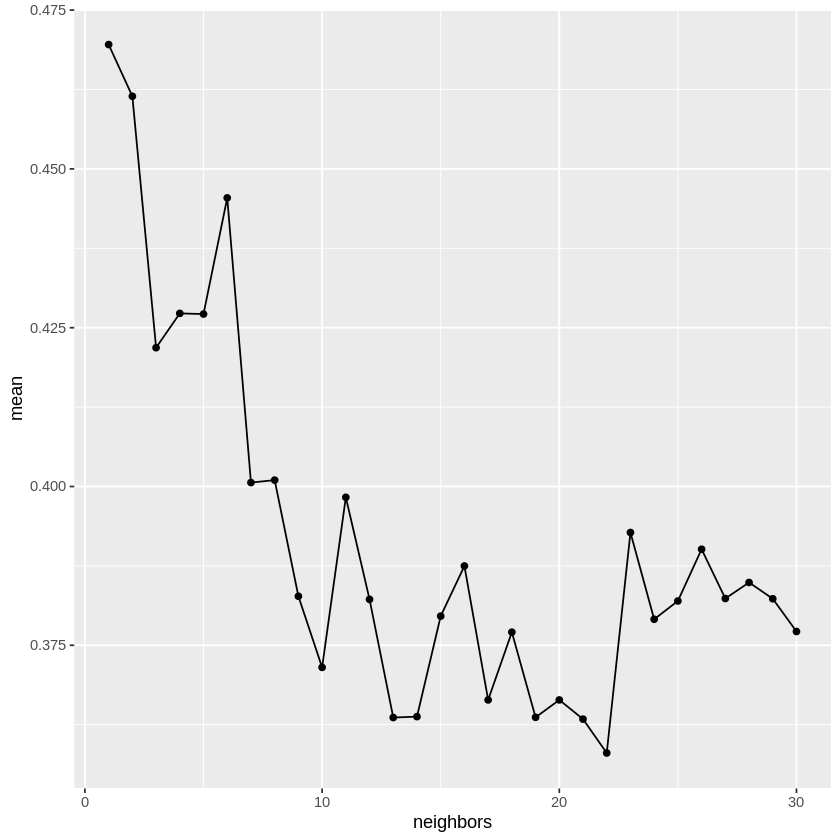

In [16]:
# Model 1.1 - Temperature
temp_recipe <- recipe(Weather ~ Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp_fit <- workflow() %>%
    add_recipe(temp_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp_accuracy <- temp_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp_accuracy

temp_accuracy_plot <- temp_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp_accuracy_plot

In [ ]:
# Model 2.1 - Humidity
humid_recipe <- recipe(Weather ~ Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid_fit <- workflow() %>%
    add_recipe(humid_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid_accuracy <- humid_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
humid_accuracy

humid_accuracy_plot <- humid_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
humid_accuracy_plot

In [ ]:
# Model 3.1 - Wind Speed
wind_recipe <- recipe(Weather ~ Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind_fit <- workflow() %>%
    add_recipe(wind_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind_accuracy <- wind_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind_accuracy

wind_accuracy_plot <- wind_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind_accuracy_plot

In [ ]:
# Model 4.1 - Visability
vis_recipe <- recipe(Weather ~ Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis_fit <- workflow() %>%
    add_recipe(vis_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis_accuracy <- vis_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis_accuracy

vis_accuracy_plot <- vis_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
vis_accuracy_plot

In [ ]:
# Model 5.1 - Air Pressure
press_recipe <- recipe(Weather ~ Press, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

press_fit <- workflow() %>%
    add_recipe(press_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

press_accuracy <- press_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
press_accuracy

press_accuracy_plot <- press_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
press_accuracy_plot

**Findings:** Using air pressure has the highest prediction accuracy so far.

In [ ]:
#### Phase 2: Two Predictor Variables

In [ ]:
# Model 1.2 - Air Pressure + Temperature
temp2_recipe <- recipe(Weather ~ Press + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp2_fit <- workflow() %>%
    add_recipe(temp2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp2_accuracy <- temp2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp2_accuracy

temp2_accuracy_plot <- temp2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp2_accuracy_plot

In [ ]:
# Model 2.2 - Air Pressure + Humidity
humid2_recipe <- recipe(Weather ~ Press + Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid2_fit <- workflow() %>%
    add_recipe(humid2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid2_accuracy <- humid2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
humid2_accuracy

humid2_accuracy_plot <- humid2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
humid2_accuracy_plot

In [ ]:
# Model 3.2 - Air Pressure + Wind Speed
wind2_recipe <- recipe(Weather ~ Press + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind2_fit <- workflow() %>%
    add_recipe(wind2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind2_accuracy <- wind2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind2_accuracy

wind2_accuracy_plot <- wind2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind2_accuracy_plot

In [ ]:
# Model 4.2 - Air Pressure + Visibility
vis2_recipe <- recipe(Weather ~ Press + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis2_fit <- workflow() %>%
    add_recipe(vis2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis2_accuracy <- vis2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis2_accuracy

vis2_accuracy_plot <- vis2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
vis2_accuracy_plot

**Findings:** Using air pressure and humidity has the highest accuracy so far.

#### Phase 3: Three Variables

In [ ]:
# Model 1.3 - Air Pressure + Humidity + Temperature
temp3_recipe <- recipe(Weather ~ Press + Humid + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp3_fit <- workflow() %>%
    add_recipe(temp3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp3_accuracy <- temp3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp3_accuracy

temp3_accuracy_plot <- temp3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp3_accuracy_plot

In [ ]:
# Model 2.3 - Air Pressure + Humidity + Wind Speed
wind3_recipe <- recipe(Weather ~ Press + Humid + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind3_fit <- workflow() %>%
    add_recipe(wind3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind3_accuracy <- wind3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind3_accuracy

wind3_accuracy_plot <- wind3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind3_accuracy_plot

In [ ]:
# Model 3.3 - Air Pressure + Humidity + Visibility
vis3_recipe <- recipe(Weather ~ Press + Humid + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis3_fit <- workflow() %>%
    add_recipe(vis3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis3_accuracy <- vis3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis3_accuracy

vis3_accuracy_plot <- vis3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
vis3_accuracy_plot

**Findings:** Using air Pressure, humidity and visibility has the highest accuracy so far.

#### Phase 4: Four Variables

In [ ]:
# Model 1.4 - Air Pressure + Humidity + Visibility + Temp
temp4_recipe <- recipe(Weather ~ Press + Humid + Vis + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp4_fit <- workflow() %>%
    add_recipe(temp4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp4_accuracy <- temp4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp4_accuracy

temp4_accuracy_plot <- temp4_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp4_accuracy_plot

In [ ]:
# Model 2.4 - Air Pressure + Humidity + Visibility + Wind Speed
wind4_recipe <- recipe(Weather ~ Press + Humid + Vis + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind4_fit <- workflow() %>%
    add_recipe(wind4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind4_accuracy <- wind4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind4_accuracy

wind4_accuracy_plot <- wind4_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind4_accuracy_plot

**Findings:** Using air Pressure, humidity, visibility and temperature has the highest in phase 4, but is not more accurate than the previous.

#### Phase 5: All variables

In [ ]:
# Model 1.5 - Air Pressure + Humidity + Visibility + Wind Speed + Temperature
all_recipe <- recipe(Weather ~ ., data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

all_fit <- workflow() %>%
    add_recipe(all_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

all_accuracy <- all_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
all_accuracy

all_accuracy_plot <- all_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
all_accuracy_plot

**Findings:** Using all predictor variables is still slightly less accurate than using the 3 variables identified in phase 3. Thus we will be using *air pressure*, *humidity*, and *visibility* as predictors in our final model. 

In [ ]:
set.seed(2022) #we need this to make our code reproducible because cross validation is a random process

#make final recipe with cross validation to find k

weather_recipe <- recipe(Weather ~ Press + Humid + Vis, data = weather_train) %>% 
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

weather_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

#find accuracy for different values of k on our model

weather_accuracy <- weather_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
weather_accuracy

In [ ]:
#create line plot with data points for accuracy estimate vs neighbors to find optimal k value
#(looking for high accuracy estimate with high values of accuracy for nearby values of k as well)

options(repr.plot.height = 8, repr.plot.width = 12)
finding_k_plot <- ggplot(weather_accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
finding_k_plot

In [ ]:
#retrain our model with the newfound value of k and fit it to our training data

#since k = 2 has the highest accuracy, we will use that in our new model

weather_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) %>% 
    set_engine("kknn") %>%
    set_mode("classification")

weather_fit_final <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_model) %>%
    fit(data = weather_train)

In [ ]:
#we can now use our fitted model to predict the weather for our testing data set

weather_predictions <- predict(weather_fit_final, weather_test) %>%
    bind_cols(weather_test) %>%
    select(.pred_class, Weather)
weather_predictions

In [ ]:
#we can use the metrics function to see how accurate our model was at predicting weather values 
#on the testing dataset

weather_metrics <- weather_predictions %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
weather_metrics

## Discussion

## References